In [11]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from pathlib import Path
import matplotlib.pyplot as plt

In [12]:
# SET MAIN HYPERPARAMETERS
STIMULUS_LABEL = "4NotTheFall"
STIMULUS_LABEL_SAVE_STRING = "notthefallintact"
CSV_FILE = "/Volumes/Passport/fmriprep/trait_ratings_data/chujun_data.csv"
OUT_DIR = Path("/Volumes/Passport/fmriprep/derivatives/RDMs_behavior")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
# Define the traits to be used

TRAIT_LIST = [
    "Open-minded",
    "feeling Affectionate",
    "Attentive",
    "Assertive",
    "feeling Gloomy",
    "feeling Peaceful",
    "Agreeable",
    "Judging",
    "feeling Angry",
    "feeling Bewildered",
    "Impulsive",
    "Self-disciplined",
    "Contemplating",
]


In [14]:
# Define the smoothing window for each trait
WIN_DICT: dict[str, int] = {
    "Open-minded"      : 200,
    "feeling Affectionate": 200,
    "Attentive"        : 200,
    "Assertive"        : 200,
    "feeling Gloomy"   : 200,
    "feeling Peaceful" : 175,
    "Agreeable"        : 200,
    "Judging"          : 150,
    "feeling Angry"    : 0,
    "feeling Bewildered": 50,
    "Impulsive"        : 25,
    "Self-disciplined" : 0,
    "Contemplating"    : 0,
}

In [15]:
# Toggle smoothing on/off 
ENABLE_SMOOTHING = False

In [16]:
# --------------------------------------------------------------------------
# MAIN FUNCTION
# --------------------------------------------------------------------------

def build_behavior_template(
        csv_path       : str | Path,
        stim_label     : str,
        trait_label    : str,
        win_dict       : dict[str, int],
        apply_smoothing: bool = True,
        tr_sec         : float = 1.5,
        n_tr           : int = 160,
        sd_cutoff      : float = 5.0,
        max_sec        : float = 240.0,
) -> tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    # (1) Load and filter data
    df = pd.read_csv(csv_path)
    df = df[(df["stim"] == stim_label)
            & (df["task"] == trait_label)
            & (df["time"]  < max_sec)].copy()

    # (2) exclude raters whose SD < sd_cutoff
    sd = df.groupby("subject")["rating"].std()
    bad_sd = sd[sd < sd_cutoff].index
    df = df[~df["subject"].isin(bad_sd)]
    print(f"Excluded {len(bad_sd)} raters (SD < {sd_cutoff}). Kept {df['subject'].nunique()} subjects.")

    # (3) Map samples to TR bins (0‥159)
    df["TR"] = (df["time"] / tr_sec).round().astype(int)
    df = df[(df["TR"] >= 0) & (df["TR"] < n_tr)]

    # (4) Smooth ratings only if enabled
    window = win_dict.get(trait_label, 0)
    if not apply_smoothing or window < 1:
        print(f"[{trait_label}] smoothing skipped (enabled={apply_smoothing}, window={window})")
        df["rating_sm"] = df["rating"]
    else:
        print(f"[{trait_label}] smoothing window={window} samples")
        df["rating_sm"] = (
            df.groupby("subject")["rating"]
              .apply(lambda s: s.rolling(window, center=True, min_periods=1).mean())
              .reset_index(level=0, drop=True)
        )

    # (5) Average across raters within each TR
    pivot = (df.pivot_table(index="TR", columns="subject",
                            values="rating_sm", aggfunc="mean")
               .reindex(range(n_tr))
               .interpolate(limit_direction="both"))
    vec = pivot.mean(axis=1).values

    # (6) Compute dissimilarity matrix (Manhattan distance)
    RDM = squareform(pdist(vec[:, None], metric="cityblock"))

    return vec, RDM, df

# %% Loop over traits: build & save
for trait in TRAIT_LIST:
    trait_save_str = trait.replace(" ", "_").replace("-", "_")
    print(f"\n=== Processing trait: {trait} ===")
    vec, RDM, df = build_behavior_template(
        csv_path        = CSV_FILE,
        stim_label      = STIMULUS_LABEL,
        trait_label     = trait,
        win_dict        = WIN_DICT,
        apply_smoothing = ENABLE_SMOOTHING,
    )
    smoothing_setting = "" if ENABLE_SMOOTHING else "_no_smoothing"
    np.save(OUT_DIR / f"{STIMULUS_LABEL_SAVE_STRING}_{trait_save_str}_vec{smoothing_setting}.npy", vec)
    np.save(OUT_DIR / f"{STIMULUS_LABEL_SAVE_STRING}_{trait_save_str}_RDM{smoothing_setting}.npy", RDM)
    print(f"Saved vector and RDM for {trait} with suffix '{smoothing_setting}'")



=== Processing trait: Open-minded ===
Excluded 2 raters (SD < 5.0). Kept 21 subjects.
[Open-minded] smoothing skipped (enabled=False, window=200)
Saved vector and RDM for Open-minded with suffix '_no_smoothing'

=== Processing trait: feeling Affectionate ===
Excluded 3 raters (SD < 5.0). Kept 17 subjects.
[feeling Affectionate] smoothing skipped (enabled=False, window=200)
Saved vector and RDM for feeling Affectionate with suffix '_no_smoothing'

=== Processing trait: Attentive ===
Excluded 2 raters (SD < 5.0). Kept 16 subjects.
[Attentive] smoothing skipped (enabled=False, window=200)
Saved vector and RDM for Attentive with suffix '_no_smoothing'

=== Processing trait: Assertive ===
Excluded 4 raters (SD < 5.0). Kept 24 subjects.
[Assertive] smoothing skipped (enabled=False, window=200)
Saved vector and RDM for Assertive with suffix '_no_smoothing'

=== Processing trait: feeling Gloomy ===
Excluded 2 raters (SD < 5.0). Kept 12 subjects.
[feeling Gloomy] smoothing skipped (enabled=Fal

In [17]:
# %% (Optional) Plot a single trait’s series & RDM
PLOT_TRAIT = "Open-minded"
plot_save_str = PLOT_TRAIT.replace(" ", "_").replace("-", "_")
suffix = "" if ENABLE_SMOOTHING else "_no_smoothing"
vec = np.load(OUT_DIR / f"{STIMULUS_LABEL_SAVE_STRING}_{plot_save_str}_vec{suffix}.npy")
RDM = np.load(OUT_DIR / f"{STIMULUS_LABEL_SAVE_STRING}_{plot_save_str}_RDM{suffix}.npy")

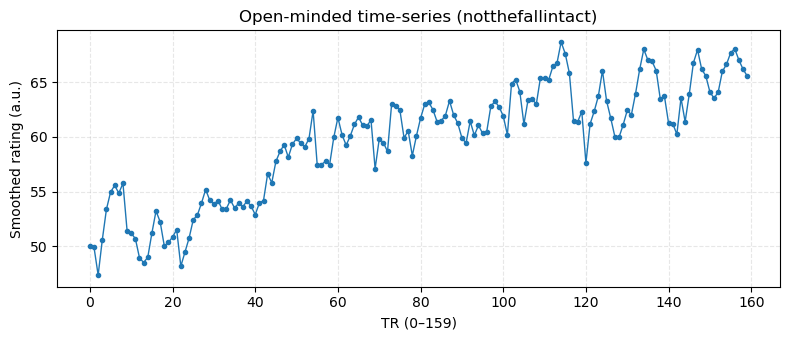

In [18]:
plt.figure(figsize=(8, 3.5))
plt.plot(np.arange(len(vec)), vec, marker="o", ms=3, lw=1)
plt.title(f"{PLOT_TRAIT} time-series ({STIMULUS_LABEL_SAVE_STRING})")
plt.xlabel("TR (0–159)")
plt.ylabel("Smoothed rating (a.u.)")
plt.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.show()

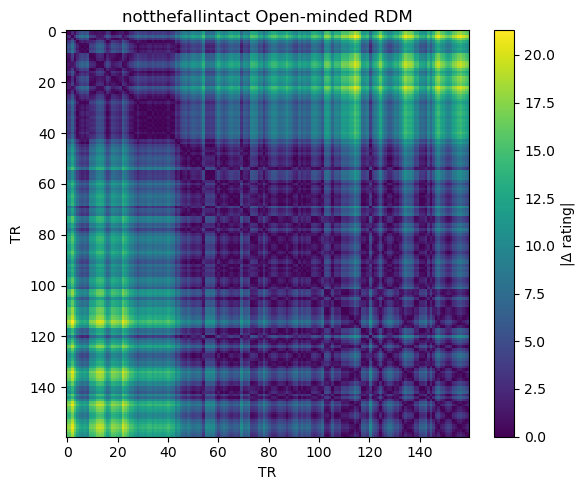

In [19]:
plt.figure(figsize=(6,5))
plt.imshow(RDM, interpolation="nearest", aspect="auto")
plt.title(f"{STIMULUS_LABEL_SAVE_STRING} {PLOT_TRAIT} RDM")
plt.xlabel("TR"); plt.ylabel("TR")
plt.colorbar(label="|Δ rating|")
plt.tight_layout()
plt.show()

In [20]:
# %% Sanity-check
assert vec.shape == (160,),  "Vector must be length 160"
assert RDM.shape == (160,160), "RDM must be 160×160"
assert np.allclose(RDM, RDM.T), "RDM not symmetric"
assert np.allclose(np.diag(RDM), 0), "Diagonal must be zeros"
assert np.allclose(RDM, squareform(pdist(vec[:,None], 'cityblock'))), \
       "RDM mismatch"
print("All checks passed ✔️")

All checks passed ✔️
